In [115]:
import simpy
import random 
import collections
import matplotlib.pyplot as plt 

In [124]:
RANDOM_SEED = 43
TICKETS = 50  # Number of tickets per movie
SIM_TIME = 120  # Simulate until

THREADS_PER_CORE = 25
CORES = 4
RESPONSE_TIME = random.randint(3, 9)
MAX_QUEUE_LEN = 10000

In [123]:
def moviegoer(env, movie, num_tickets, theater):
    """A moviegoer tries to by a number of tickets (*num_tickets*) for
    a certain *movie* in a *theater*.

    If the movie becomes sold out, she leaves the theater. If she gets
    to the counter, she tries to buy a number of tickets. If not enough
    tickets are left, she argues with the teller and leaves.

    If at most one ticket is left after the moviegoer bought her
    tickets, the *sold out* event for this movie is triggered causing
    all remaining moviegoers to leave.

    """
    with theater.counter.request() as my_turn:
        # Wait until its our turn or until the movie is sold out
        result = yield my_turn | theater.sold_out[movie]

        # Check if it's our turn or if movie is sold out
        if my_turn not in result:
            theater.num_renegers[movie] += 1
            return

        # Check if enough tickets left.
        if theater.available[movie] < num_tickets:
            # Moviegoer leaves after some discussion
            yield env.timeout(0.5)
            return

        # Buy tickets
        theater.available[movie] -= num_tickets
        if theater.available[movie] < 2:
            # Trigger the "sold out" event for the movie
            theater.sold_out[movie].succeed()
            theater.when_sold_out[movie] = env.now
            theater.available[movie] = 0
        yield env.timeout(1)


def customer_arrivals(env, theater):
    """Create new *moviegoers* until the sim time reaches 120."""
    while True:
        if Monday:
            avg_req_min = 500
        elif Tuesday:
            avg_req_min = 600
        elif Wednesday:
            avg_req_min = 700
        elif Thursday:
            avg_req_min = 500
        elif Friday:
            avg_req_min = 400
        elif Saturday:
            avg_req_min = 200
        elif Sunday:
            avg_req_min = 250
        
        if afternoon:
            avg_req_min = avg_req_min * 1.5
        elif night:
            avg_req_min = 0.5
        
        yield env.timeout(1 / avg_req_min)

        movie = random.choice(theater.movies)
        num_tickets = random.randint(1, 6)
        if theater.available[movie]:
            env.process(moviegoer(env, movie, num_tickets, theater))

            
Theater = collections.namedtuple('Theater', 'counter, movies, available, '
                                            'sold_out, when_sold_out, '
                                            'num_renegers')


# Setup and start the simulation
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Create movie theater
counter = simpy.Resource(env, capacity=1)
movies = ['Python Unchained', 'Kill Process', 'Pulp Implementation']
available = {movie: TICKETS for movie in movies}
sold_out = {movie: env.event() for movie in movies}
when_sold_out = {movie: None for movie in movies}
num_renegers = {movie: 0 for movie in movies}
theater = Theater(counter, movies, available, sold_out, when_sold_out,
                  num_renegers)

# Start process and run
env.process(customer_arrivals(env, theater))
env.run(until=SIM_TIME)


if theater.sold_out['Python Unchained']:
    print('Movie "%s" sold out %.1f minutes after ticket counter '
          'opening.' % (movie, theater.when_sold_out[movie]))
    print('  Number of people leaving queue when film sold out: %s' %
          theater.num_renegers[movie])

NameError: name 'Monday' is not defined

In [3]:
def car(env):
     while True:
         print('Start parking at %d' % env.now)
         parking_duration = 5
         yield env.timeout(parking_duration)

         print('Start driving at %d' % env.now)
         trip_duration = 2
         yield env.timeout(trip_duration)

In [4]:
env = simpy.Environment()
env.process(car(env))
env.run(until=15)

Start parking at 0
Start driving at 5
Start parking at 7
Start driving at 12
Start parking at 14


In [98]:
REQUEST_INTERVAL = .2
MAX_REQ_LOAD = 1
TIME_TO_RESPOND = 1
HOUR = 61

In [104]:
class Server(object):
    def __init__(self, env, max_req_load, time_to_respond):
        self.env = env
        self.requests = simpy.Resource(env, max_req_load)
        self.time_to_respond = time_to_respond
        
    def respond_request(self, request):
        print(f"sending request for {request}")
        yield self.env.timeout(self.time_to_respond)
        print(f"request {request} served at {env.now}")
        
def request_event(env, name, server):
    print(f"{name} requesting")
    with server.requests.request() as request:
        yield request
        yield env.process(server.respond_request(name))

In [105]:
def page_requests(env, request_interval, max_req_load, time_to_respond):
    server = Server(env, max_req_load, time_to_respond)
    i = 0
    while True:
        yield env.timeout(request_interval)
        i += 1
        print(f"TIME {i}")
        env.process(request_event(env, f"Request {i}", server))

In [106]:
env = simpy.Environment()
env.process(page_requests(env, REQUEST_INTERVAL, MAX_REQ_LOAD, TIME_TO_RESPOND))
env.run(until=HOUR)

TIME 1
Request 1 requesting
sending request for Request 1
TIME 2
Request 2 requesting
TIME 3
Request 3 requesting
TIME 4
Request 4 requesting
TIME 5
Request 5 requesting
request Request 1 served at 1.2
TIME 6
Request 6 requesting
sending request for Request 2
TIME 7
Request 7 requesting
TIME 8
Request 8 requesting
TIME 9
Request 9 requesting
TIME 10
Request 10 requesting
TIME 11
Request 11 requesting
request Request 2 served at 2.2
sending request for Request 3
TIME 12
Request 12 requesting
TIME 13
Request 13 requesting
TIME 14
Request 14 requesting
TIME 15
Request 15 requesting
request Request 3 served at 3.2
sending request for Request 4
TIME 16
Request 16 requesting
TIME 17
Request 17 requesting
TIME 18
Request 18 requesting
TIME 19
Request 19 requesting
TIME 20
Request 20 requesting
request Request 4 served at 4.2
sending request for Request 5
TIME 21
Request 21 requesting
TIME 22
Request 22 requesting
TIME 23
Request 23 requesting
TIME 24
Request 24 requesting
TIME 25
Request 25 r

In [111]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience

In [112]:
def source(env, number, interval, counter):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counter, time_in_bank=12.0)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter, time_in_bank):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            print('%7.4f %s: Finished' % (env.now, name))

        else:
            # We reneged
            print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))

In [113]:
# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 3.8595 Customer00: Finished
10.2006 Customer01: Here I am
10.2006 Customer01: Waited  0.000
12.7265 Customer02: Here I am
13.9003 Customer02: RENEGED after  1.174
23.7507 Customer01: Finished
34.9993 Customer03: Here I am
34.9993 Customer03: Waited  0.000
37.9599 Customer03: Finished
40.4798 Customer04: Here I am
40.4798 Customer04: Waited  0.000
43.1401 Customer04: Finished


In [117]:
RANDOM_SEED = 43
TICKETS = 50  # Number of tickets per movie
SIM_TIME = 120  # Simulate until


def moviegoer(env, movie, num_tickets, theater):
    """A moviegoer tries to by a number of tickets (*num_tickets*) for
    a certain *movie* in a *theater*.

    If the movie becomes sold out, she leaves the theater. If she gets
    to the counter, she tries to buy a number of tickets. If not enough
    tickets are left, she argues with the teller and leaves.

    If at most one ticket is left after the moviegoer bought her
    tickets, the *sold out* event for this movie is triggered causing
    all remaining moviegoers to leave.

    """
    with theater.counter.request() as my_turn:
        # Wait until its our turn or until the movie is sold out
        result = yield my_turn | theater.sold_out[movie]

        # Check if it's our turn or if movie is sold out
        if my_turn not in result:
            theater.num_renegers[movie] += 1
            return

        # Check if enough tickets left.
        if theater.available[movie] < num_tickets:
            # Moviegoer leaves after some discussion
            yield env.timeout(0.5)
            return

        # Buy tickets
        theater.available[movie] -= num_tickets
        if theater.available[movie] < 2:
            # Trigger the "sold out" event for the movie
            theater.sold_out[movie].succeed()
            theater.when_sold_out[movie] = env.now
            theater.available[movie] = 0
        yield env.timeout(1)


def customer_arrivals(env, theater):
    """Create new *moviegoers* until the sim time reaches 120."""
    while True:
        yield env.timeout(random.expovariate(1 / 0.5))

        movie = random.choice(theater.movies)
        num_tickets = random.randint(1, 6)
        if theater.available[movie]:
            env.process(moviegoer(env, movie, num_tickets, theater))


Theater = collections.namedtuple('Theater', 'counter, movies, available, '
                                            'sold_out, when_sold_out, '
                                            'num_renegers')


# Setup and start the simulation
print('Movie renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Create movie theater
counter = simpy.Resource(env, capacity=1)
movies = ['Python Unchained', 'Kill Process', 'Pulp Implementation']
available = {movie: TICKETS for movie in movies}
sold_out = {movie: env.event() for movie in movies}
when_sold_out = {movie: None for movie in movies}
num_renegers = {movie: 0 for movie in movies}
theater = Theater(counter, movies, available, sold_out, when_sold_out,
                  num_renegers)

# Start process and run
env.process(customer_arrivals(env, theater))
env.run(until=SIM_TIME)

# Analysis/results
for movie in movies:
    if theater.sold_out[movie]:
        print('Movie "%s" sold out %.1f minutes after ticket counter '
              'opening.' % (movie, theater.when_sold_out[movie]))
        print('  Number of people leaving queue when film sold out: %s' %
              theater.num_renegers[movie])

Movie renege
Movie "Python Unchained" sold out 49.1 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 15
Movie "Kill Process" sold out 51.1 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 12
Movie "Pulp Implementation" sold out 47.1 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 12


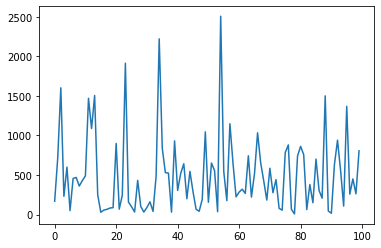

In [125]:
# store the random numbers in a  
# list 
nums = [] 
alpha = 3
    
for i in range(100): 
    temp = random.expovariate(1 / 500)
    nums.append(temp) 
        
# plotting a graph 
plt.plot(nums) 
plt.show()